In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pyvibdmc.analysis import *
from pyvibdmc.simulation_utilities import *
import tensorflow as tf
from tensorflow.keras import layers, models
from try_descriptors import *

(9901, 6, 3)
(9850, 6, 3)
(9858, 6, 3)
hello


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [13]:
def load_training(training_name):
    """If using deb_training_every argument, read the files with this."""
    with h5py.File(training_name, 'r') as f:
        cds = f['coords'][:]
        vs = f['pots'][:]
    return cds, Constants.convert(vs, "wavenumbers", to_AU=False)


def get_ml_data(ts):
    tot_x = []
    tot_v = []
    for time in ts:
        cds, vs = load_training(f"training_0_training_{time}ts.hdf5")
        tot_x.append(cds.squeeze())
        tot_v.append(vs)
    tot_x = np.concatenate(tot_x)
    tot_v = np.concatenate(tot_v)
    return tot_x, tot_v

tss = [1000,1500,2000,3000,3500,4000,4500]
train_x, train_y = get_ml_data(tss)
train_x = coulomb_it(train_x)


val_set = [2500]
val_x, val_y = get_ml_data(val_set)
val_x = coulomb_it(val_x)

In [44]:
def vectorize(clmat):
    tril_map = 1 - np.tril(np.ones((6,6)))
    cleanmat = np.multiply(clmat, tril_map).flatten()
    return cleanmat[cleanmat != 0]

train_x_vec = np.array([vectorize(mat) for mat in train_x])
val_x_vec = np.array([vectorize(mat) for mat in val_x])

def normalize(vec, mx, mn):
    return 2*(vec-mn)/(mx-mn) - 1

train_x_vec = normalize(train_x_vec, 5, 0)
val_x_vec = normalize(val_x_vec, 5, 0)

In [81]:
model = tf.keras.Sequential()

model.add(layers.Input(shape=(15,)))
model.add(layers.Dense(256, activation=tf.nn.swish))
model.add(layers.Dense(256, activation=tf.nn.swish))
model.add(layers.Dense(256, activation=tf.nn.swish))
model.add(layers.Dense(1, activation='linear'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 256)               4096      
_________________________________________________________________
dense_21 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 257       
Total params: 135,937
Trainable params: 135,937
Non-trainable params: 0
_________________________________________________________________


In [82]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
                 loss='mse',
                 metrics=[])

In [85]:
history = model.fit(train_x_vec, np.log10(train_y), validation_split=0.1, batch_size=32, epochs=500)

Epoch 1/500
1944/1944 [==============================] - 4s 2ms/step - loss: 7.4954e-04 - val_loss: 6.9421e-04
Epoch 2/500
1944/1944 [==============================] - 4s 2ms/step - loss: 6.9782e-04 - val_loss: 0.0021
Epoch 3/500
1944/1944 [==============================] - 4s 2ms/step - loss: 7.2225e-04 - val_loss: 0.0011
Epoch 4/500
1944/1944 [==============================] - 4s 2ms/step - loss: 6.6714e-04 - val_loss: 8.0620e-04
Epoch 5/500
1944/1944 [==============================] - 4s 2ms/step - loss: 7.0982e-04 - val_loss: 5.2806e-04
Epoch 6/500
1944/1944 [==============================] - 4s 2ms/step - loss: 7.3297e-04 - val_loss: 4.1821e-04
Epoch 7/500
1944/1944 [==============================] - 4s 2ms/step - loss: 6.4447e-04 - val_loss: 7.8471e-04
Epoch 8/500
1944/1944 [==============================] - 4s 2ms/step - loss: 6.5464e-04 - val_loss: 6.0389e-04
Epoch 9/500
1944/1944 [==============================] - 4s 2ms/step - loss: 6.4743e-04 - val_loss: 5.7514e-04
Epoch 10/

KeyboardInterrupt: 

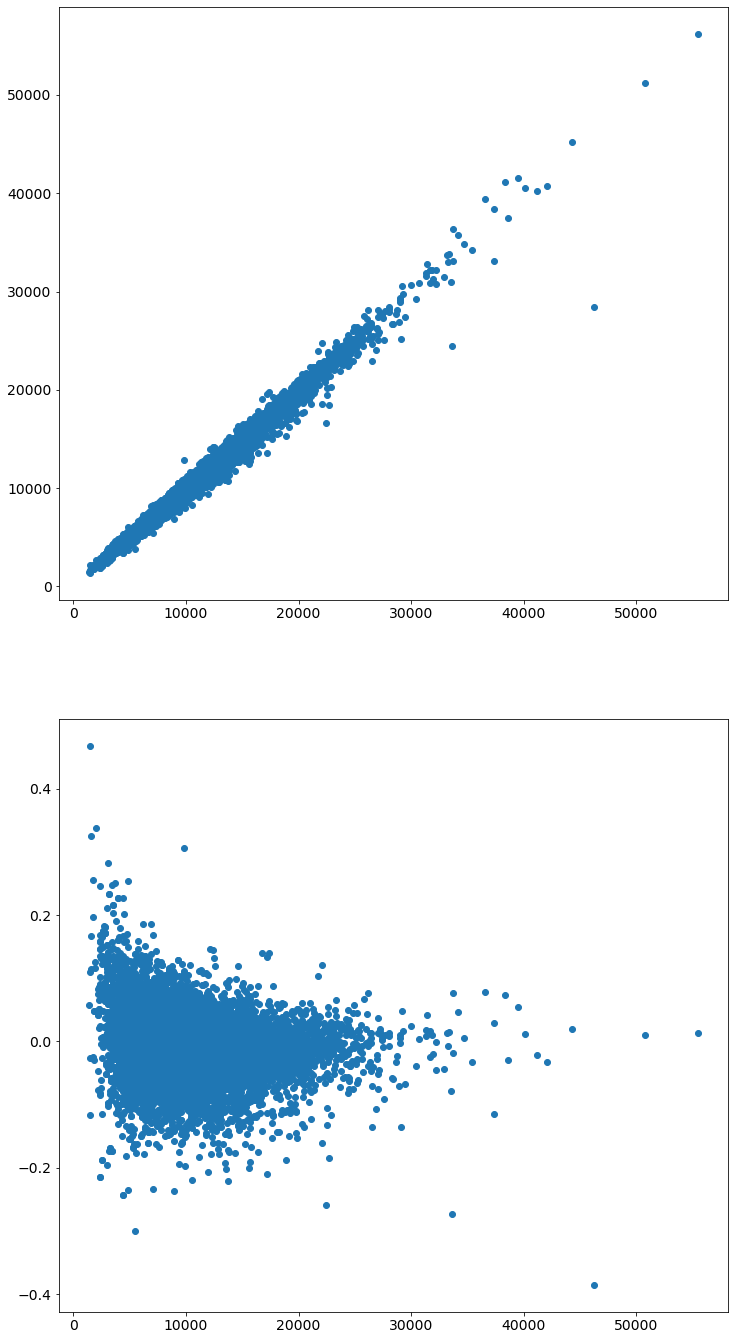

In [86]:
def plot_dis_vec(x1, x2):
    fig = plt.figure(figsize=(12,24))

    loss = fig.add_subplot(2,1,1)
    loss.scatter(x1, x2)
    
    percent_loss = fig.add_subplot(2,1,2)
    percent_loss.scatter(x1, (x2-x1)/x1)
    
    plt.show()
    
plot_dis_vec(val_y[:,np.newaxis], 10**model.predict(val_x_vec))

In [87]:
model.save_weights('coulomb_3x256.h5')